In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
import time

In [4]:
Skin_data = np.load('SFA_Filter_S.npy')
NonSkin_data=np.load('SFA_Filter_NS.npy')

In [5]:
input_data=[]
for i in range(2):
    if i == 0:
        for j in range(len(NonSkin_data)):
            input_data.append(NonSkin_data[j])
    else :
        for j in range(len(Skin_data)):
            input_data.append(Skin_data[j])

In [6]:
label=[]
for i in range(len(NonSkin_data)+len(Skin_data)):
    if i>len(NonSkin_data):
        label.append(0)
    else:
        label.append(1)

In [7]:
label=np.array(label)
input_data=np.array(input_data)

In [8]:
input_data= (input_data*(1/256)-0.5)/0.5

In [9]:
input_data.shape

(1753024, 9, 5)

In [10]:
input_data=torch.FloatTensor(input_data)
label=torch.LongTensor(label)

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
dataset = TensorDataset(input_data,label)

In [12]:
trainset,valset=torch.utils.data.random_split(dataset,[1403024,350000])
trainset,testset=torch.utils.data.random_split(trainset,[1053024,350000])

partition={'train':trainset,'val':valset,'test':testset}

In [19]:
class GCN(nn.Module):
    def __init__(self,hid_dim,hid_dim1,hid_dim2):
        super(GCN,self).__init__()
        self.hid_dim=hid_dim
        self.hid_dim1=hid_dim1
        self.hid_dim2=hid_dim2
        A = [[1, 1, 0, 1, 1, 0, 0, 0, 0],
             [1, 1, 1, 1, 1, 1, 0, 0, 0],
             [0 ,1, 1, 0, 1, 1, 0, 0, 0],
             [1, 1, 0, 1, 1, 0, 1, 1, 0],
             [1, 1, 1, 1, 1, 1, 1, 1, 1],
             [0, 1, 1, 0, 1, 1, 0, 1, 1],
             [0, 0, 0, 1, 1, 0, 1, 1, 0],
             [0, 0, 0, 1, 1, 1, 1, 1, 1],
             [0, 0, 0, 0, 1, 1, 0, 1, 1]]
        adj=torch.FloatTensor(A)
        adj=adj.cuda()
        self.adj=adj
        self.W= nn.Parameter(torch.detach(torch.rand(5,self.hid_dim)).requires_grad_(True))
        self.W1= nn.Parameter(torch.detach(torch.rand(self.hid_dim,self.hid_dim1)).requires_grad_(True))#hid_dim이라 생각하면 편함
        self.W2= nn.Parameter(torch.detach(torch.rand(self.hid_dim1,self.hid_dim2)).requires_grad_(True))
        self.act = nn.Sigmoid()
        self.Linear=nn.Linear(self.hid_dim2,1)
        self.Linear1=nn.Linear(9,2)
        
    def forward(self,x):
        outs=[]
        out = torch.matmul(x,self.W)
        out = self.act(out)
        out = torch.matmul(self.adj,out)
        out = torch.matmul(out,self.W1)
        out = self.act(out)
        out = torch.matmul(self.adj,out)
        out = torch.matmul(out,self.W2)
        out = self.act(out)
        out = torch.matmul(self.adj,out)
        
        mic1,mic2,mic3,mic4,mic5,mic6,mic7,mic8,mic9=torch.chunk(out,9,-2)
        #print(mic1,mic1.shape)
        x1= self.Linear(mic1)
        x2= self.Linear(mic2)
        x3= self.Linear(mic3)
        x4= self.Linear(mic4)
        x5= self.Linear(mic5)
        x6= self.Linear(mic6)
        x7= self.Linear(mic7)
        x8= self.Linear(mic8)
        x9= self.Linear(mic9)
        out1=torch.cat([x1,x2,x3,x4,x5,x6,x7,x8,x9],1)
        out1=torch.squeeze(out1)
        out1=self.act(out1)
        out1 =self.Linear1(out1)
        return out1

In [23]:
def train(net,partition,optimizer,criterion):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                             batch_size=4096,
                                             shuffle=True)
    net.train()
    correct = 0
    total =0
    train_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 0)):
        time.sleep(0.0000001)
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        #break
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #if i % 200 == 0:
        #    print(correct,train_loss)
    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [15]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=4096, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [16]:
def validate(net, partition, criterion):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=4096, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in tqdm(valloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [30]:
def experiment(partition, args):
    net=GCN(args.hid_dim,args.hid_dim1,args.hid_dim2)
    net.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0015, weight_decay=0.00001)
    train_losses=[]
    val_losses=[]
    train_accs=[]
    val_accs=[]
    for epoch in range(args.epoch):
        ts=time.time()
        net, train_loss,train_acc=train(net, partition, optimizer, criterion)
        val_loss, val_acc = validate(net, partition, criterion)
        te=time.time()
        print('time : {:2.2f}, train_loss : {:2.2f}, train_acc : {:2.2f},val_acc : {:2.2f},val_loss : {:2.2f}'.format(te-ts,train_loss,train_acc,val_acc,val_loss))

        train_loss=round(train_loss,2)#리스트에 넣기 위해 3번째 자릿수 반올림
        val_loss=round(val_loss,2)
        train_acc=round(train_acc,2)
        val_acc=round(val_acc,2)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)    


    torch.save(net,'/home/lab/양창희/pytorch/pytorch_GCN/model/model_h_{}h1_{}.pt'.format(args.hid_dim1,args.hid_dim2))
    test_acc = test(net,partition,criterion)
    test_acc=round(test_acc,2)
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [31]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp_hid"
args.epoch = 20
args.hid_dim=10
name_var1='hid_dim1'
name_var2='hid_dim2'
list_var1=[15,20,25,30]
list_var2=[20,30,40,50]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) #args.name_var1 = var1
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

  1%|          | 2/258 [00:00<00:20, 12.63it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=15, hid_dim2=20)


  1%|          | 2/258 [00:00<00:14, 17.55it/s]

time : 12.07, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:14, 17.52it/s]

time : 12.28, train_loss : 0.53, train_acc : 70.79,val_acc : 85.76,val_loss : 0.34


  1%|          | 2/258 [00:00<00:14, 18.17it/s]

time : 12.08, train_loss : 0.24, train_acc : 91.84,val_acc : 92.71,val_loss : 0.21


  1%|          | 2/258 [00:00<00:16, 15.93it/s]

time : 12.06, train_loss : 0.21, train_acc : 92.84,val_acc : 92.94,val_loss : 0.20


  0%|          | 1/258 [00:00<00:42,  6.09it/s]

time : 12.30, train_loss : 0.19, train_acc : 93.09,val_acc : 93.20,val_loss : 0.19


  1%|          | 2/258 [00:00<00:14, 18.22it/s]

time : 12.27, train_loss : 0.19, train_acc : 93.24,val_acc : 93.32,val_loss : 0.19


  0%|          | 1/258 [00:00<00:34,  7.51it/s]

time : 12.30, train_loss : 0.19, train_acc : 93.38,val_acc : 93.33,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 17.74it/s]

time : 12.21, train_loss : 0.18, train_acc : 93.47,val_acc : 93.46,val_loss : 0.19


  1%|          | 2/258 [00:00<00:22, 11.18it/s]

time : 12.52, train_loss : 0.18, train_acc : 93.50,val_acc : 93.48,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 17.80it/s]

time : 12.54, train_loss : 0.18, train_acc : 93.60,val_acc : 93.67,val_loss : 0.18


  1%|          | 2/258 [00:00<00:22, 11.58it/s]

time : 12.40, train_loss : 0.17, train_acc : 93.73,val_acc : 93.76,val_loss : 0.17


  1%|          | 2/258 [00:00<00:17, 14.55it/s]

time : 12.39, train_loss : 0.16, train_acc : 94.25,val_acc : 94.89,val_loss : 0.14


  1%|          | 2/258 [00:00<00:16, 15.49it/s]

time : 12.33, train_loss : 0.13, train_acc : 95.14,val_acc : 95.14,val_loss : 0.13


  1%|          | 2/258 [00:00<00:13, 19.34it/s]

time : 12.30, train_loss : 0.13, train_acc : 95.23,val_acc : 95.19,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.64it/s]

time : 12.36, train_loss : 0.13, train_acc : 95.26,val_acc : 95.09,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.77it/s]

time : 12.40, train_loss : 0.13, train_acc : 95.27,val_acc : 95.27,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.28it/s]

time : 12.68, train_loss : 0.13, train_acc : 95.29,val_acc : 95.11,val_loss : 0.13


  0%|          | 1/258 [00:00<00:44,  5.73it/s]

time : 12.54, train_loss : 0.13, train_acc : 95.29,val_acc : 95.24,val_loss : 0.13


  1%|          | 2/258 [00:00<00:18, 14.20it/s]

time : 12.68, train_loss : 0.13, train_acc : 95.32,val_acc : 95.27,val_loss : 0.13


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.47, train_loss : 0.13, train_acc : 95.32,val_acc : 95.31,val_loss : 0.13


  0%|          | 1/258 [00:00<00:44,  5.73it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=15, hid_dim2=30)


  0%|          | 1/258 [00:00<00:25,  9.97it/s]

time : 12.33, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.60


  1%|          | 2/258 [00:00<00:21, 11.69it/s]

time : 12.47, train_loss : 0.39, train_acc : 79.82,val_acc : 92.18,val_loss : 0.26


  0%|          | 1/258 [00:00<00:26,  9.86it/s]

time : 12.46, train_loss : 0.23, train_acc : 92.52,val_acc : 92.70,val_loss : 0.22


  1%|          | 2/258 [00:00<00:22, 11.19it/s]

time : 12.71, train_loss : 0.20, train_acc : 92.89,val_acc : 92.99,val_loss : 0.20


  1%|          | 2/258 [00:00<00:18, 14.18it/s]

time : 12.47, train_loss : 0.19, train_acc : 93.21,val_acc : 93.33,val_loss : 0.19


  1%|          | 2/258 [00:00<00:14, 18.18it/s]

time : 12.71, train_loss : 0.19, train_acc : 93.39,val_acc : 93.47,val_loss : 0.19


  1%|          | 2/258 [00:00<00:17, 14.60it/s]

time : 12.45, train_loss : 0.18, train_acc : 93.48,val_acc : 93.36,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 17.52it/s]

time : 12.51, train_loss : 0.18, train_acc : 93.57,val_acc : 93.50,val_loss : 0.18


  0%|          | 1/258 [00:00<00:35,  7.34it/s]

time : 12.38, train_loss : 0.17, train_acc : 93.72,val_acc : 93.87,val_loss : 0.17


  1%|          | 2/258 [00:00<00:17, 14.23it/s]

time : 12.38, train_loss : 0.16, train_acc : 94.20,val_acc : 94.69,val_loss : 0.15


  0%|          | 1/258 [00:00<00:37,  6.89it/s]

time : 12.70, train_loss : 0.14, train_acc : 95.09,val_acc : 95.18,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.22it/s]

time : 12.23, train_loss : 0.13, train_acc : 95.23,val_acc : 95.04,val_loss : 0.13


  1%|          | 2/258 [00:00<00:22, 11.43it/s]

time : 12.30, train_loss : 0.13, train_acc : 95.26,val_acc : 95.23,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.20it/s]

time : 12.54, train_loss : 0.13, train_acc : 95.28,val_acc : 95.21,val_loss : 0.13


  1%|          | 2/258 [00:00<00:21, 11.85it/s]

time : 12.42, train_loss : 0.13, train_acc : 95.29,val_acc : 95.20,val_loss : 0.13


  1%|          | 2/258 [00:00<00:15, 16.52it/s]

time : 12.39, train_loss : 0.13, train_acc : 95.29,val_acc : 95.24,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.09it/s]

time : 12.30, train_loss : 0.13, train_acc : 95.31,val_acc : 95.27,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.51it/s]

time : 12.69, train_loss : 0.13, train_acc : 95.32,val_acc : 95.25,val_loss : 0.13


  1%|          | 2/258 [00:00<00:18, 14.18it/s]

time : 12.51, train_loss : 0.13, train_acc : 95.34,val_acc : 95.25,val_loss : 0.13


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.58, train_loss : 0.13, train_acc : 95.34,val_acc : 95.25,val_loss : 0.13


  1%|          | 2/258 [00:00<00:15, 16.36it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=15, hid_dim2=40)


  1%|          | 2/258 [00:00<00:14, 17.78it/s]

time : 12.11, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  0%|          | 1/258 [00:00<00:36,  7.08it/s]

time : 12.55, train_loss : 0.62, train_acc : 67.29,val_acc : 84.72,val_loss : 0.44


  1%|          | 2/258 [00:00<00:14, 17.96it/s]

time : 12.26, train_loss : 0.29, train_acc : 91.64,val_acc : 92.60,val_loss : 0.24


  0%|          | 1/258 [00:00<00:43,  5.87it/s]

time : 12.44, train_loss : 0.23, train_acc : 93.00,val_acc : 93.22,val_loss : 0.21


  1%|          | 2/258 [00:00<00:14, 17.95it/s]

time : 12.43, train_loss : 0.17, train_acc : 94.42,val_acc : 94.71,val_loss : 0.16


  0%|          | 1/258 [00:00<00:25,  9.95it/s]

time : 12.56, train_loss : 0.15, train_acc : 95.08,val_acc : 95.05,val_loss : 0.15


  1%|          | 2/258 [00:00<00:18, 14.12it/s]

time : 12.37, train_loss : 0.14, train_acc : 95.19,val_acc : 95.16,val_loss : 0.14


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.60, train_loss : 0.14, train_acc : 95.21,val_acc : 95.16,val_loss : 0.14


  1%|          | 2/258 [00:00<00:17, 14.26it/s]

time : 12.78, train_loss : 0.14, train_acc : 95.23,val_acc : 95.11,val_loss : 0.14


  1%|          | 2/258 [00:00<00:14, 17.91it/s]

time : 12.49, train_loss : 0.13, train_acc : 95.26,val_acc : 95.22,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.39it/s]

time : 12.27, train_loss : 0.13, train_acc : 95.27,val_acc : 95.17,val_loss : 0.14


  0%|          | 1/258 [00:00<00:26,  9.86it/s]

time : 12.66, train_loss : 0.13, train_acc : 95.28,val_acc : 95.24,val_loss : 0.13


  0%|          | 1/258 [00:00<00:34,  7.46it/s]

time : 12.57, train_loss : 0.13, train_acc : 95.29,val_acc : 95.20,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.74it/s]

time : 12.09, train_loss : 0.13, train_acc : 95.28,val_acc : 95.21,val_loss : 0.13


  0%|          | 1/258 [00:00<00:41,  6.14it/s]

time : 12.58, train_loss : 0.13, train_acc : 95.31,val_acc : 95.23,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.85it/s]

time : 12.52, train_loss : 0.13, train_acc : 95.30,val_acc : 95.25,val_loss : 0.13


  1%|          | 2/258 [00:00<00:25, 10.12it/s]

time : 12.52, train_loss : 0.13, train_acc : 95.30,val_acc : 95.07,val_loss : 0.14


  1%|          | 2/258 [00:00<00:13, 18.50it/s]

time : 12.15, train_loss : 0.13, train_acc : 95.31,val_acc : 95.29,val_loss : 0.13


  1%|          | 2/258 [00:00<00:22, 11.42it/s]

time : 12.53, train_loss : 0.13, train_acc : 95.32,val_acc : 95.27,val_loss : 0.13


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.17, train_loss : 0.13, train_acc : 95.32,val_acc : 95.16,val_loss : 0.13


  1%|          | 2/258 [00:00<00:13, 18.31it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=15, hid_dim2=50)


  1%|          | 2/258 [00:00<00:16, 15.76it/s]

time : 12.44, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:15, 16.74it/s]

time : 12.40, train_loss : 0.55, train_acc : 69.87,val_acc : 83.59,val_loss : 0.37


  0%|          | 1/258 [00:00<00:25,  9.92it/s]

time : 12.44, train_loss : 0.26, train_acc : 90.43,val_acc : 92.54,val_loss : 0.22


  1%|          | 2/258 [00:00<00:14, 18.24it/s]

time : 12.64, train_loss : 0.21, train_acc : 92.70,val_acc : 92.84,val_loss : 0.20


  1%|          | 2/258 [00:00<00:14, 17.94it/s]

time : 12.13, train_loss : 0.20, train_acc : 93.06,val_acc : 93.22,val_loss : 0.19


  0%|          | 1/258 [00:00<00:44,  5.79it/s]

time : 12.74, train_loss : 0.19, train_acc : 93.33,val_acc : 93.48,val_loss : 0.19


  1%|          | 2/258 [00:00<00:14, 17.58it/s]

time : 12.89, train_loss : 0.18, train_acc : 93.46,val_acc : 93.46,val_loss : 0.18


  0%|          | 1/258 [00:00<00:42,  6.01it/s]

time : 12.35, train_loss : 0.18, train_acc : 93.56,val_acc : 93.45,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 17.39it/s]

time : 12.30, train_loss : 0.18, train_acc : 93.64,val_acc : 93.59,val_loss : 0.18


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.59, train_loss : 0.17, train_acc : 93.77,val_acc : 93.84,val_loss : 0.17


  0%|          | 1/258 [00:00<00:25,  9.96it/s]

time : 12.18, train_loss : 0.17, train_acc : 93.91,val_acc : 93.94,val_loss : 0.17


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.65, train_loss : 0.16, train_acc : 94.11,val_acc : 94.11,val_loss : 0.16


  1%|          | 2/258 [00:00<00:15, 16.40it/s]

time : 12.22, train_loss : 0.15, train_acc : 94.67,val_acc : 95.21,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.91it/s]

time : 12.48, train_loss : 0.13, train_acc : 95.31,val_acc : 95.27,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.00it/s]

time : 12.44, train_loss : 0.13, train_acc : 95.32,val_acc : 95.30,val_loss : 0.13


  1%|          | 2/258 [00:00<00:13, 18.70it/s]

time : 12.34, train_loss : 0.13, train_acc : 95.35,val_acc : 95.32,val_loss : 0.13


  0%|          | 1/258 [00:00<00:41,  6.12it/s]

time : 12.55, train_loss : 0.13, train_acc : 95.36,val_acc : 95.36,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.96it/s]

time : 12.26, train_loss : 0.13, train_acc : 95.39,val_acc : 95.32,val_loss : 0.13


  0%|          | 1/258 [00:00<00:32,  7.92it/s]

time : 12.49, train_loss : 0.12, train_acc : 95.40,val_acc : 95.31,val_loss : 0.13


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.38, train_loss : 0.12, train_acc : 95.41,val_acc : 95.37,val_loss : 0.12


  1%|          | 2/258 [00:00<00:14, 17.09it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=20, hid_dim2=20)


  1%|          | 2/258 [00:00<00:22, 11.48it/s]

time : 12.31, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:14, 18.14it/s]

time : 12.57, train_loss : 0.62, train_acc : 64.22,val_acc : 82.62,val_loss : 0.40


  0%|          | 1/258 [00:00<00:26,  9.88it/s]

time : 12.19, train_loss : 0.28, train_acc : 89.16,val_acc : 92.62,val_loss : 0.22


  1%|          | 2/258 [00:00<00:17, 14.36it/s]

time : 12.58, train_loss : 0.21, train_acc : 92.86,val_acc : 93.02,val_loss : 0.20


  0%|          | 1/258 [00:00<00:26,  9.75it/s]

time : 12.20, train_loss : 0.19, train_acc : 93.24,val_acc : 93.38,val_loss : 0.19


  1%|          | 2/258 [00:00<00:17, 14.68it/s]

time : 12.64, train_loss : 0.18, train_acc : 93.60,val_acc : 93.77,val_loss : 0.17


  1%|          | 2/258 [00:00<00:16, 15.68it/s]

time : 12.23, train_loss : 0.16, train_acc : 94.46,val_acc : 95.03,val_loss : 0.14


  1%|          | 2/258 [00:00<00:14, 17.36it/s]

time : 12.22, train_loss : 0.13, train_acc : 95.15,val_acc : 95.20,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.71it/s]

time : 12.54, train_loss : 0.13, train_acc : 95.27,val_acc : 95.21,val_loss : 0.13


  0%|          | 1/258 [00:00<00:37,  6.78it/s]

time : 12.74, train_loss : 0.13, train_acc : 95.28,val_acc : 95.11,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.48it/s]

time : 12.66, train_loss : 0.13, train_acc : 95.28,val_acc : 95.21,val_loss : 0.13


  0%|          | 1/258 [00:00<00:42,  5.99it/s]

time : 12.57, train_loss : 0.13, train_acc : 95.31,val_acc : 95.24,val_loss : 0.13


  1%|          | 2/258 [00:00<00:15, 16.90it/s]

time : 12.17, train_loss : 0.13, train_acc : 95.33,val_acc : 95.16,val_loss : 0.13


  1%|          | 2/258 [00:00<00:22, 11.34it/s]

time : 12.64, train_loss : 0.13, train_acc : 95.33,val_acc : 95.29,val_loss : 0.13


  1%|          | 2/258 [00:00<00:13, 18.38it/s]

time : 12.52, train_loss : 0.13, train_acc : 95.34,val_acc : 95.29,val_loss : 0.13


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.49, train_loss : 0.12, train_acc : 95.35,val_acc : 95.31,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.11it/s]

time : 12.32, train_loss : 0.12, train_acc : 95.36,val_acc : 95.33,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.29it/s]

time : 12.28, train_loss : 0.12, train_acc : 95.37,val_acc : 95.28,val_loss : 0.13


  1%|          | 2/258 [00:00<00:18, 14.15it/s]

time : 12.33, train_loss : 0.12, train_acc : 95.37,val_acc : 95.34,val_loss : 0.12


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.57, train_loss : 0.12, train_acc : 95.38,val_acc : 95.27,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.13it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=20, hid_dim2=30)


  0%|          | 1/258 [00:00<00:33,  7.65it/s]

time : 12.64, train_loss : 0.66, train_acc : 62.19,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:17, 14.83it/s]

time : 12.44, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  0%|          | 1/258 [00:00<00:42,  6.07it/s]

time : 12.43, train_loss : 0.50, train_acc : 77.97,val_acc : 92.18,val_loss : 0.29


  1%|          | 2/258 [00:00<00:17, 14.39it/s]

time : 12.43, train_loss : 0.25, train_acc : 92.72,val_acc : 92.85,val_loss : 0.23


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.50, train_loss : 0.21, train_acc : 93.24,val_acc : 94.51,val_loss : 0.18


  0%|          | 1/258 [00:00<00:26,  9.70it/s]

time : 12.29, train_loss : 0.16, train_acc : 94.87,val_acc : 94.55,val_loss : 0.16


  0%|          | 1/258 [00:00<00:25,  9.94it/s]

time : 12.52, train_loss : 0.15, train_acc : 95.11,val_acc : 95.07,val_loss : 0.15


  1%|          | 2/258 [00:00<00:17, 14.63it/s]

time : 12.23, train_loss : 0.14, train_acc : 95.15,val_acc : 95.13,val_loss : 0.14


  1%|          | 2/258 [00:00<00:22, 11.62it/s]

time : 12.17, train_loss : 0.14, train_acc : 95.17,val_acc : 95.06,val_loss : 0.14


  0%|          | 1/258 [00:00<00:26,  9.76it/s]

time : 12.30, train_loss : 0.14, train_acc : 95.19,val_acc : 95.13,val_loss : 0.14


  1%|          | 2/258 [00:00<00:14, 17.58it/s]

time : 12.56, train_loss : 0.13, train_acc : 95.21,val_acc : 95.19,val_loss : 0.13


  0%|          | 1/258 [00:00<00:26,  9.72it/s]

time : 12.56, train_loss : 0.13, train_acc : 95.24,val_acc : 95.20,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.88it/s]

time : 12.21, train_loss : 0.13, train_acc : 95.26,val_acc : 95.21,val_loss : 0.13


  0%|          | 1/258 [00:00<00:42,  6.12it/s]

time : 12.27, train_loss : 0.13, train_acc : 95.29,val_acc : 95.19,val_loss : 0.13


  1%|          | 2/258 [00:00<00:13, 18.76it/s]

time : 12.22, train_loss : 0.13, train_acc : 95.30,val_acc : 95.21,val_loss : 0.13


  0%|          | 1/258 [00:00<00:34,  7.39it/s]

time : 12.09, train_loss : 0.13, train_acc : 95.32,val_acc : 95.26,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.80it/s]

time : 12.27, train_loss : 0.13, train_acc : 95.33,val_acc : 95.22,val_loss : 0.13


  1%|          | 2/258 [00:00<00:21, 11.90it/s]

time : 12.42, train_loss : 0.13, train_acc : 95.33,val_acc : 95.30,val_loss : 0.13


  1%|          | 2/258 [00:00<00:13, 18.33it/s]

time : 12.55, train_loss : 0.13, train_acc : 95.35,val_acc : 95.32,val_loss : 0.13


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.32, train_loss : 0.13, train_acc : 95.37,val_acc : 95.34,val_loss : 0.13


  1%|          | 2/258 [00:00<00:22, 11.47it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=20, hid_dim2=40)


  1%|          | 2/258 [00:00<00:14, 17.62it/s]

time : 12.43, train_loss : 0.66, train_acc : 61.61,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:14, 17.76it/s]

time : 12.09, train_loss : 0.63, train_acc : 64.42,val_acc : 82.07,val_loss : 0.40


  1%|          | 2/258 [00:00<00:14, 17.86it/s]

time : 12.51, train_loss : 0.29, train_acc : 88.92,val_acc : 92.41,val_loss : 0.23


  1%|          | 2/258 [00:00<00:13, 19.02it/s]

time : 12.13, train_loss : 0.21, train_acc : 92.63,val_acc : 92.75,val_loss : 0.20


  0%|          | 1/258 [00:00<00:41,  6.21it/s]

time : 12.40, train_loss : 0.20, train_acc : 92.85,val_acc : 92.89,val_loss : 0.20


  0%|          | 1/258 [00:00<00:25,  9.90it/s]

time : 12.65, train_loss : 0.20, train_acc : 92.98,val_acc : 92.97,val_loss : 0.20


  0%|          | 1/258 [00:00<00:35,  7.26it/s]

time : 12.56, train_loss : 0.19, train_acc : 93.04,val_acc : 93.00,val_loss : 0.19


  1%|          | 2/258 [00:00<00:17, 14.58it/s]

time : 12.29, train_loss : 0.19, train_acc : 93.16,val_acc : 93.14,val_loss : 0.19


  0%|          | 1/258 [00:00<00:35,  7.25it/s]

time : 12.34, train_loss : 0.18, train_acc : 93.40,val_acc : 93.35,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 18.21it/s]

time : 12.25, train_loss : 0.18, train_acc : 93.62,val_acc : 93.83,val_loss : 0.17


  1%|          | 2/258 [00:00<00:23, 10.89it/s]

time : 12.25, train_loss : 0.15, train_acc : 94.64,val_acc : 95.02,val_loss : 0.14


  1%|          | 2/258 [00:00<00:14, 17.92it/s]

time : 12.17, train_loss : 0.13, train_acc : 95.25,val_acc : 95.22,val_loss : 0.13


  1%|          | 2/258 [00:00<00:22, 11.31it/s]

time : 12.29, train_loss : 0.13, train_acc : 95.31,val_acc : 95.26,val_loss : 0.13


  1%|          | 2/258 [00:00<00:15, 16.68it/s]

time : 12.48, train_loss : 0.13, train_acc : 95.31,val_acc : 95.16,val_loss : 0.13


  1%|          | 2/258 [00:00<00:18, 14.14it/s]

time : 12.36, train_loss : 0.13, train_acc : 95.33,val_acc : 95.30,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.78it/s]

time : 12.47, train_loss : 0.13, train_acc : 95.33,val_acc : 95.26,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.49it/s]

time : 12.45, train_loss : 0.13, train_acc : 95.36,val_acc : 95.30,val_loss : 0.13


  0%|          | 1/258 [00:00<00:35,  7.22it/s]

time : 12.57, train_loss : 0.13, train_acc : 95.35,val_acc : 95.14,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.93it/s]

time : 12.28, train_loss : 0.12, train_acc : 95.37,val_acc : 95.28,val_loss : 0.13


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.31, train_loss : 0.12, train_acc : 95.37,val_acc : 95.35,val_loss : 0.12


  0%|          | 1/258 [00:00<00:34,  7.44it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=20, hid_dim2=50)


  1%|          | 2/258 [00:00<00:14, 18.02it/s]

time : 12.27, train_loss : 0.66, train_acc : 62.29,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:21, 12.07it/s]

time : 12.55, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:18, 14.17it/s]

time : 12.21, train_loss : 0.59, train_acc : 66.90,val_acc : 84.13,val_loss : 0.37


  1%|          | 2/258 [00:00<00:21, 11.99it/s]

time : 12.34, train_loss : 0.25, train_acc : 91.32,val_acc : 92.63,val_loss : 0.21


  1%|          | 2/258 [00:00<00:14, 18.09it/s]

time : 12.15, train_loss : 0.21, train_acc : 92.80,val_acc : 92.98,val_loss : 0.20


  1%|          | 2/258 [00:00<00:16, 15.31it/s]

time : 12.18, train_loss : 0.20, train_acc : 93.04,val_acc : 93.17,val_loss : 0.19


  1%|          | 2/258 [00:00<00:16, 15.45it/s]

time : 12.60, train_loss : 0.19, train_acc : 93.22,val_acc : 93.21,val_loss : 0.19


  1%|          | 2/258 [00:00<00:15, 16.16it/s]

time : 12.14, train_loss : 0.18, train_acc : 93.41,val_acc : 93.29,val_loss : 0.18


  0%|          | 1/258 [00:00<00:25,  9.93it/s]

time : 12.36, train_loss : 0.18, train_acc : 93.49,val_acc : 93.55,val_loss : 0.18


  1%|          | 2/258 [00:00<00:15, 16.67it/s]

time : 12.49, train_loss : 0.18, train_acc : 93.52,val_acc : 93.12,val_loss : 0.18


  0%|          | 1/258 [00:00<00:35,  7.16it/s]

time : 12.28, train_loss : 0.18, train_acc : 93.56,val_acc : 93.58,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 18.24it/s]

time : 12.46, train_loss : 0.18, train_acc : 93.57,val_acc : 93.35,val_loss : 0.18


  0%|          | 1/258 [00:00<00:35,  7.34it/s]

time : 12.28, train_loss : 0.18, train_acc : 93.60,val_acc : 93.58,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 17.87it/s]

time : 12.13, train_loss : 0.18, train_acc : 93.64,val_acc : 93.66,val_loss : 0.18


  1%|          | 2/258 [00:00<00:21, 11.70it/s]

time : 12.34, train_loss : 0.18, train_acc : 93.63,val_acc : 93.46,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 17.75it/s]

time : 12.26, train_loss : 0.17, train_acc : 93.70,val_acc : 93.68,val_loss : 0.17


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.34, train_loss : 0.17, train_acc : 93.79,val_acc : 93.79,val_loss : 0.17


  1%|          | 2/258 [00:00<00:14, 17.31it/s]

time : 12.29, train_loss : 0.17, train_acc : 93.95,val_acc : 93.94,val_loss : 0.17


  1%|          | 2/258 [00:00<00:14, 17.89it/s]

time : 12.58, train_loss : 0.16, train_acc : 94.19,val_acc : 94.33,val_loss : 0.16


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.43, train_loss : 0.15, train_acc : 94.58,val_acc : 94.94,val_loss : 0.14


  1%|          | 2/258 [00:00<00:14, 18.04it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=25, hid_dim2=20)


  1%|          | 2/258 [00:00<00:17, 14.59it/s]

time : 12.20, train_loss : 0.72, train_acc : 44.89,val_acc : 62.46,val_loss : 0.68


  0%|          | 1/258 [00:00<00:42,  6.10it/s]

time : 12.16, train_loss : 0.67, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:14, 17.99it/s]

time : 12.32, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  0%|          | 1/258 [00:00<00:35,  7.16it/s]

time : 12.50, train_loss : 0.48, train_acc : 81.82,val_acc : 92.19,val_loss : 0.32


  1%|          | 2/258 [00:00<00:14, 17.93it/s]

time : 12.28, train_loss : 0.28, train_acc : 92.68,val_acc : 92.81,val_loss : 0.26


  1%|          | 2/258 [00:00<00:22, 11.60it/s]

time : 12.31, train_loss : 0.24, train_acc : 92.91,val_acc : 92.88,val_loss : 0.24


  1%|          | 2/258 [00:00<00:14, 18.28it/s]

time : 12.61, train_loss : 0.23, train_acc : 92.99,val_acc : 92.90,val_loss : 0.22


  1%|          | 2/258 [00:00<00:22, 11.54it/s]

time : 12.60, train_loss : 0.22, train_acc : 92.98,val_acc : 92.94,val_loss : 0.22


  1%|          | 2/258 [00:00<00:16, 15.16it/s]

time : 12.25, train_loss : 0.21, train_acc : 92.99,val_acc : 92.94,val_loss : 0.21


  0%|          | 1/258 [00:00<00:25,  9.97it/s]

time : 12.13, train_loss : 0.21, train_acc : 93.03,val_acc : 92.91,val_loss : 0.21


  1%|          | 2/258 [00:00<00:16, 15.72it/s]

time : 12.23, train_loss : 0.20, train_acc : 93.09,val_acc : 92.98,val_loss : 0.20


  0%|          | 1/258 [00:00<00:25,  9.98it/s]

time : 12.42, train_loss : 0.20, train_acc : 93.27,val_acc : 93.34,val_loss : 0.19


  1%|          | 2/258 [00:00<00:17, 14.69it/s]

time : 12.47, train_loss : 0.19, train_acc : 93.50,val_acc : 93.56,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 17.65it/s]

time : 12.29, train_loss : 0.15, train_acc : 94.78,val_acc : 95.10,val_loss : 0.14


  0%|          | 1/258 [00:00<00:34,  7.46it/s]

time : 12.17, train_loss : 0.13, train_acc : 95.31,val_acc : 95.31,val_loss : 0.13


  0%|          | 1/258 [00:00<00:26,  9.77it/s]

time : 12.12, train_loss : 0.13, train_acc : 95.34,val_acc : 95.31,val_loss : 0.13


  0%|          | 1/258 [00:00<00:35,  7.28it/s]

time : 12.47, train_loss : 0.13, train_acc : 95.37,val_acc : 95.32,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.56it/s]

time : 12.27, train_loss : 0.13, train_acc : 95.38,val_acc : 95.34,val_loss : 0.13


  1%|          | 2/258 [00:00<00:21, 11.94it/s]

time : 12.54, train_loss : 0.13, train_acc : 95.39,val_acc : 95.33,val_loss : 0.13


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.29, train_loss : 0.13, train_acc : 95.40,val_acc : 95.35,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.56it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=25, hid_dim2=30)


  1%|          | 2/258 [00:00<00:21, 11.94it/s]

time : 12.33, train_loss : 0.66, train_acc : 62.21,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:14, 17.51it/s]

time : 12.11, train_loss : 0.60, train_acc : 66.76,val_acc : 82.84,val_loss : 0.37


  1%|          | 2/258 [00:00<00:17, 14.28it/s]

time : 12.59, train_loss : 0.26, train_acc : 90.00,val_acc : 92.64,val_loss : 0.21


  1%|          | 2/258 [00:00<00:14, 17.63it/s]

time : 12.25, train_loss : 0.20, train_acc : 92.80,val_acc : 92.81,val_loss : 0.20


  1%|          | 2/258 [00:00<00:15, 16.21it/s]

time : 12.12, train_loss : 0.19, train_acc : 93.11,val_acc : 93.27,val_loss : 0.19


  0%|          | 1/258 [00:00<00:36,  7.10it/s]

time : 12.60, train_loss : 0.19, train_acc : 93.37,val_acc : 93.22,val_loss : 0.19


  1%|          | 2/258 [00:00<00:14, 17.92it/s]

time : 12.61, train_loss : 0.18, train_acc : 93.49,val_acc : 93.32,val_loss : 0.18


  0%|          | 1/258 [00:00<00:42,  6.03it/s]

time : 12.38, train_loss : 0.17, train_acc : 93.67,val_acc : 94.00,val_loss : 0.17


  1%|          | 2/258 [00:00<00:16, 15.57it/s]

time : 12.24, train_loss : 0.15, train_acc : 94.70,val_acc : 95.10,val_loss : 0.13


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.60, train_loss : 0.13, train_acc : 95.19,val_acc : 95.18,val_loss : 0.13


  1%|          | 2/258 [00:00<00:16, 15.86it/s]

time : 12.33, train_loss : 0.13, train_acc : 95.25,val_acc : 95.21,val_loss : 0.13


  1%|          | 2/258 [00:00<00:21, 11.80it/s]

time : 12.21, train_loss : 0.13, train_acc : 95.28,val_acc : 95.21,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.08it/s]

time : 12.19, train_loss : 0.13, train_acc : 95.30,val_acc : 95.19,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.76it/s]

time : 12.10, train_loss : 0.13, train_acc : 95.31,val_acc : 95.24,val_loss : 0.13


  1%|          | 2/258 [00:00<00:15, 16.02it/s]

time : 12.22, train_loss : 0.13, train_acc : 95.35,val_acc : 95.31,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.31it/s]

time : 12.05, train_loss : 0.13, train_acc : 95.36,val_acc : 95.29,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.59it/s]

time : 12.51, train_loss : 0.13, train_acc : 95.37,val_acc : 95.20,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.75it/s]

time : 12.17, train_loss : 0.13, train_acc : 95.38,val_acc : 95.26,val_loss : 0.13


  0%|          | 1/258 [00:00<00:42,  5.98it/s]

time : 12.19, train_loss : 0.13, train_acc : 95.39,val_acc : 95.35,val_loss : 0.13


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.57, train_loss : 0.13, train_acc : 95.39,val_acc : 95.32,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.15it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=25, hid_dim2=40)


  0%|          | 1/258 [00:00<00:42,  6.04it/s]

time : 12.35, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:14, 18.05it/s]

time : 12.27, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  0%|          | 1/258 [00:00<00:25,  9.94it/s]

time : 12.39, train_loss : 0.44, train_acc : 78.01,val_acc : 91.53,val_loss : 0.24


  1%|          | 2/258 [00:00<00:17, 14.39it/s]

time : 12.53, train_loss : 0.22, train_acc : 92.50,val_acc : 92.74,val_loss : 0.20


  1%|          | 2/258 [00:00<00:22, 11.35it/s]

time : 12.47, train_loss : 0.20, train_acc : 92.89,val_acc : 92.92,val_loss : 0.20


  0%|          | 1/258 [00:00<00:25,  9.99it/s]

time : 12.13, train_loss : 0.19, train_acc : 93.07,val_acc : 92.86,val_loss : 0.19


  1%|          | 2/258 [00:00<00:17, 14.42it/s]

time : 12.66, train_loss : 0.19, train_acc : 93.26,val_acc : 93.33,val_loss : 0.19


  1%|          | 2/258 [00:00<00:17, 14.56it/s]

time : 12.67, train_loss : 0.18, train_acc : 93.40,val_acc : 93.45,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 18.26it/s]

time : 12.36, train_loss : 0.18, train_acc : 93.49,val_acc : 93.53,val_loss : 0.18


  0%|          | 1/258 [00:00<00:44,  5.81it/s]

time : 12.21, train_loss : 0.18, train_acc : 93.52,val_acc : 93.57,val_loss : 0.18


  0%|          | 1/258 [00:00<00:26,  9.78it/s]

time : 12.67, train_loss : 0.18, train_acc : 93.58,val_acc : 93.41,val_loss : 0.18


  0%|          | 1/258 [00:00<00:41,  6.22it/s]

time : 12.28, train_loss : 0.18, train_acc : 93.64,val_acc : 93.62,val_loss : 0.18


  1%|          | 2/258 [00:00<00:17, 14.66it/s]

time : 12.19, train_loss : 0.17, train_acc : 93.81,val_acc : 93.83,val_loss : 0.17


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.66, train_loss : 0.16, train_acc : 94.12,val_acc : 94.13,val_loss : 0.16


  1%|          | 2/258 [00:00<00:16, 15.27it/s]

time : 12.34, train_loss : 0.14, train_acc : 94.93,val_acc : 95.21,val_loss : 0.13


  1%|          | 2/258 [00:00<00:22, 11.37it/s]

time : 12.84, train_loss : 0.13, train_acc : 95.31,val_acc : 95.28,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.32it/s]

time : 12.52, train_loss : 0.13, train_acc : 95.33,val_acc : 95.18,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.46it/s]

time : 12.37, train_loss : 0.13, train_acc : 95.35,val_acc : 95.28,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.35it/s]

time : 12.52, train_loss : 0.12, train_acc : 95.38,val_acc : 95.22,val_loss : 0.13


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.28, train_loss : 0.12, train_acc : 95.40,val_acc : 95.36,val_loss : 0.12


  1%|          | 2/258 [00:00<00:17, 14.53it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=25, hid_dim2=50)


  1%|          | 2/258 [00:00<00:14, 17.16it/s]

time : 12.20, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:14, 17.77it/s]

time : 12.40, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.59


  0%|          | 1/258 [00:00<00:35,  7.20it/s]

time : 12.67, train_loss : 0.32, train_acc : 86.21,val_acc : 92.44,val_loss : 0.23


  1%|          | 2/258 [00:00<00:17, 14.37it/s]

time : 12.61, train_loss : 0.21, train_acc : 92.60,val_acc : 92.77,val_loss : 0.21


  0%|          | 1/258 [00:00<00:45,  5.67it/s]

time : 12.24, train_loss : 0.20, train_acc : 92.88,val_acc : 92.91,val_loss : 0.20


  1%|          | 2/258 [00:00<00:14, 18.16it/s]

time : 12.48, train_loss : 0.19, train_acc : 93.16,val_acc : 93.04,val_loss : 0.19


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.39, train_loss : 0.18, train_acc : 93.40,val_acc : 93.42,val_loss : 0.18


  1%|          | 2/258 [00:00<00:15, 17.06it/s]

time : 12.45, train_loss : 0.18, train_acc : 93.56,val_acc : 93.54,val_loss : 0.18


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.61, train_loss : 0.17, train_acc : 93.72,val_acc : 93.67,val_loss : 0.17


  1%|          | 2/258 [00:00<00:15, 17.03it/s]

time : 12.33, train_loss : 0.17, train_acc : 93.90,val_acc : 93.98,val_loss : 0.17


  1%|          | 2/258 [00:00<00:17, 14.38it/s]

time : 12.56, train_loss : 0.16, train_acc : 94.38,val_acc : 94.99,val_loss : 0.14


  1%|          | 2/258 [00:00<00:17, 14.33it/s]

time : 12.51, train_loss : 0.13, train_acc : 95.26,val_acc : 95.29,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.63it/s]

time : 12.38, train_loss : 0.13, train_acc : 95.33,val_acc : 95.24,val_loss : 0.13


  0%|          | 1/258 [00:00<00:39,  6.44it/s]

time : 12.46, train_loss : 0.13, train_acc : 95.36,val_acc : 95.24,val_loss : 0.13


  1%|          | 2/258 [00:00<00:13, 18.78it/s]

time : 12.22, train_loss : 0.13, train_acc : 95.37,val_acc : 95.29,val_loss : 0.13


  0%|          | 1/258 [00:00<00:42,  6.10it/s]

time : 12.37, train_loss : 0.13, train_acc : 95.39,val_acc : 95.21,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.10it/s]

time : 12.41, train_loss : 0.13, train_acc : 95.39,val_acc : 95.28,val_loss : 0.13


  1%|          | 2/258 [00:00<00:22, 11.26it/s]

time : 12.72, train_loss : 0.13, train_acc : 95.39,val_acc : 95.29,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.11it/s]

time : 12.80, train_loss : 0.13, train_acc : 95.39,val_acc : 95.37,val_loss : 0.13


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.53, train_loss : 0.12, train_acc : 95.42,val_acc : 95.39,val_loss : 0.13


  1%|          | 2/258 [00:00<00:21, 12.10it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=30, hid_dim2=20)


  1%|          | 2/258 [00:00<00:17, 14.27it/s]

time : 12.14, train_loss : 0.67, train_acc : 60.31,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:22, 11.52it/s]

time : 12.52, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.55


  0%|          | 1/258 [00:00<00:25,  9.98it/s]

time : 12.29, train_loss : 0.34, train_acc : 85.67,val_acc : 92.46,val_loss : 0.24


  1%|          | 2/258 [00:00<00:14, 17.73it/s]

time : 12.49, train_loss : 0.22, train_acc : 92.66,val_acc : 92.60,val_loss : 0.21


  1%|          | 2/258 [00:00<00:14, 17.37it/s]

time : 12.06, train_loss : 0.20, train_acc : 93.02,val_acc : 93.21,val_loss : 0.19


  1%|          | 2/258 [00:00<00:14, 18.24it/s]

time : 12.53, train_loss : 0.19, train_acc : 93.35,val_acc : 93.42,val_loss : 0.18


  0%|          | 1/258 [00:00<00:35,  7.23it/s]

time : 12.07, train_loss : 0.18, train_acc : 93.55,val_acc : 93.67,val_loss : 0.18


  1%|          | 2/258 [00:00<00:13, 18.31it/s]

time : 12.45, train_loss : 0.17, train_acc : 93.84,val_acc : 93.91,val_loss : 0.17


  0%|          | 1/258 [00:00<00:35,  7.31it/s]

time : 12.37, train_loss : 0.16, train_acc : 94.38,val_acc : 94.79,val_loss : 0.15


  1%|          | 2/258 [00:00<00:14, 17.46it/s]

time : 12.18, train_loss : 0.13, train_acc : 95.20,val_acc : 95.29,val_loss : 0.13


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.56, train_loss : 0.13, train_acc : 95.31,val_acc : 95.25,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.31it/s]

time : 12.17, train_loss : 0.13, train_acc : 95.34,val_acc : 95.32,val_loss : 0.13


  1%|          | 2/258 [00:00<00:21, 11.84it/s]

time : 12.58, train_loss : 0.13, train_acc : 95.35,val_acc : 95.32,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.06it/s]

time : 12.49, train_loss : 0.13, train_acc : 95.38,val_acc : 95.27,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.19it/s]

time : 12.16, train_loss : 0.13, train_acc : 95.37,val_acc : 95.31,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.94it/s]

time : 12.02, train_loss : 0.13, train_acc : 95.38,val_acc : 95.32,val_loss : 0.13


  1%|          | 2/258 [00:00<00:13, 18.87it/s]

time : 12.20, train_loss : 0.12, train_acc : 95.41,val_acc : 95.20,val_loss : 0.13


  0%|          | 1/258 [00:00<00:39,  6.48it/s]

time : 12.44, train_loss : 0.12, train_acc : 95.42,val_acc : 95.38,val_loss : 0.12


  1%|          | 2/258 [00:00<00:14, 17.86it/s]

time : 12.29, train_loss : 0.12, train_acc : 95.42,val_acc : 95.37,val_loss : 0.12


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.24, train_loss : 0.12, train_acc : 95.45,val_acc : 95.34,val_loss : 0.13


  0%|          | 1/258 [00:00<00:41,  6.14it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=30, hid_dim2=30)


  1%|          | 2/258 [00:00<00:17, 14.62it/s]

time : 12.19, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  0%|          | 1/258 [00:00<00:35,  7.24it/s]

time : 12.39, train_loss : 0.63, train_acc : 63.17,val_acc : 82.28,val_loss : 0.41


  1%|          | 2/258 [00:00<00:14, 18.09it/s]

time : 12.54, train_loss : 0.30, train_acc : 88.88,val_acc : 92.66,val_loss : 0.22


  0%|          | 1/258 [00:00<00:26,  9.85it/s]

time : 12.28, train_loss : 0.21, train_acc : 92.78,val_acc : 92.79,val_loss : 0.20


  1%|          | 2/258 [00:00<00:14, 17.90it/s]

time : 12.33, train_loss : 0.20, train_acc : 93.02,val_acc : 93.12,val_loss : 0.19


  1%|          | 2/258 [00:00<00:23, 10.89it/s]

time : 12.67, train_loss : 0.19, train_acc : 93.23,val_acc : 93.28,val_loss : 0.19


  1%|          | 2/258 [00:00<00:14, 18.04it/s]

time : 12.37, train_loss : 0.19, train_acc : 93.37,val_acc : 93.39,val_loss : 0.18


  1%|          | 2/258 [00:00<00:15, 16.41it/s]

time : 12.31, train_loss : 0.18, train_acc : 93.51,val_acc : 93.55,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 17.79it/s]

time : 12.26, train_loss : 0.18, train_acc : 93.70,val_acc : 93.92,val_loss : 0.17


  1%|          | 2/258 [00:00<00:13, 18.36it/s]

time : 12.14, train_loss : 0.16, train_acc : 94.32,val_acc : 94.77,val_loss : 0.14


  0%|          | 1/258 [00:00<00:34,  7.47it/s]

time : 12.50, train_loss : 0.13, train_acc : 95.19,val_acc : 95.18,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.69it/s]

time : 12.27, train_loss : 0.13, train_acc : 95.26,val_acc : 95.21,val_loss : 0.13


  0%|          | 1/258 [00:00<00:34,  7.50it/s]

time : 12.42, train_loss : 0.13, train_acc : 95.28,val_acc : 95.24,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.36it/s]

time : 12.34, train_loss : 0.13, train_acc : 95.31,val_acc : 95.19,val_loss : 0.13


  1%|          | 2/258 [00:00<00:21, 11.99it/s]

time : 12.24, train_loss : 0.13, train_acc : 95.33,val_acc : 95.17,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.23it/s]

time : 12.18, train_loss : 0.13, train_acc : 95.35,val_acc : 95.26,val_loss : 0.13


  1%|          | 2/258 [00:00<00:24, 10.27it/s]

time : 12.37, train_loss : 0.13, train_acc : 95.37,val_acc : 95.33,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.26it/s]

time : 12.30, train_loss : 0.13, train_acc : 95.38,val_acc : 95.29,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.65it/s]

time : 12.34, train_loss : 0.13, train_acc : 95.38,val_acc : 95.15,val_loss : 0.13


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.62, train_loss : 0.13, train_acc : 95.39,val_acc : 95.22,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.35it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=30, hid_dim2=40)


  1%|          | 2/258 [00:00<00:16, 15.14it/s]

time : 12.59, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:14, 17.59it/s]

time : 12.31, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  0%|          | 1/258 [00:00<00:26,  9.72it/s]

time : 12.20, train_loss : 0.53, train_acc : 72.19,val_acc : 92.05,val_loss : 0.26


  0%|          | 1/258 [00:00<00:38,  6.69it/s]

time : 12.83, train_loss : 0.22, train_acc : 92.48,val_acc : 92.46,val_loss : 0.21


  1%|          | 2/258 [00:00<00:14, 18.20it/s]

time : 12.18, train_loss : 0.20, train_acc : 92.82,val_acc : 92.89,val_loss : 0.20


  0%|          | 1/258 [00:00<00:43,  5.91it/s]

time : 12.12, train_loss : 0.20, train_acc : 92.97,val_acc : 93.00,val_loss : 0.20


  0%|          | 1/258 [00:00<00:25,  9.95it/s]

time : 12.21, train_loss : 0.19, train_acc : 93.05,val_acc : 93.10,val_loss : 0.19


  1%|          | 2/258 [00:00<00:21, 12.13it/s]

time : 12.61, train_loss : 0.19, train_acc : 93.26,val_acc : 93.36,val_loss : 0.19


  1%|          | 2/258 [00:00<00:14, 17.78it/s]

time : 12.02, train_loss : 0.18, train_acc : 93.45,val_acc : 93.50,val_loss : 0.18


  1%|          | 2/258 [00:00<00:23, 11.08it/s]

time : 12.07, train_loss : 0.18, train_acc : 93.62,val_acc : 93.59,val_loss : 0.17


  1%|          | 2/258 [00:00<00:14, 17.71it/s]

time : 12.44, train_loss : 0.16, train_acc : 94.24,val_acc : 94.92,val_loss : 0.14


  1%|          | 2/258 [00:00<00:17, 14.46it/s]

time : 12.47, train_loss : 0.13, train_acc : 95.24,val_acc : 94.71,val_loss : 0.14


  1%|          | 2/258 [00:00<00:15, 16.58it/s]

time : 12.40, train_loss : 0.13, train_acc : 95.32,val_acc : 95.31,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.68it/s]

time : 12.08, train_loss : 0.13, train_acc : 95.34,val_acc : 95.23,val_loss : 0.13


  0%|          | 1/258 [00:00<00:43,  5.88it/s]

time : 12.56, train_loss : 0.13, train_acc : 95.35,val_acc : 95.16,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 14.58it/s]

time : 12.20, train_loss : 0.13, train_acc : 95.35,val_acc : 95.34,val_loss : 0.13


  0%|          | 1/258 [00:00<00:42,  6.09it/s]

time : 12.12, train_loss : 0.13, train_acc : 95.36,val_acc : 95.27,val_loss : 0.13


  1%|          | 2/258 [00:00<00:17, 15.02it/s]

time : 12.57, train_loss : 0.12, train_acc : 95.37,val_acc : 95.34,val_loss : 0.13


  1%|          | 2/258 [00:00<00:25, 10.03it/s]

time : 12.49, train_loss : 0.12, train_acc : 95.38,val_acc : 95.34,val_loss : 0.12


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.15, train_loss : 0.12, train_acc : 95.41,val_acc : 95.28,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 18.24it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=10, hid_dim1=30, hid_dim2=50)


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.64, train_loss : 0.66, train_acc : 62.39,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:13, 18.81it/s]

time : 12.62, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:15, 16.06it/s]

time : 12.32, train_loss : 0.66, train_acc : 62.49,val_acc : 62.46,val_loss : 0.66


  1%|          | 2/258 [00:00<00:14, 17.88it/s]

time : 12.16, train_loss : 0.43, train_acc : 79.59,val_acc : 92.22,val_loss : 0.23


  0%|          | 1/258 [00:00<00:26,  9.87it/s]

time : 12.52, train_loss : 0.22, train_acc : 92.43,val_acc : 92.51,val_loss : 0.21


  1%|          | 2/258 [00:00<00:17, 14.27it/s]

time : 12.31, train_loss : 0.20, train_acc : 92.69,val_acc : 92.72,val_loss : 0.20


  1%|          | 2/258 [00:00<00:17, 14.55it/s]

time : 12.38, train_loss : 0.20, train_acc : 92.87,val_acc : 92.77,val_loss : 0.20


  0%|          | 1/258 [00:00<00:35,  7.32it/s]

time : 12.35, train_loss : 0.20, train_acc : 92.88,val_acc : 92.60,val_loss : 0.20


  1%|          | 2/258 [00:00<00:14, 18.12it/s]

time : 12.01, train_loss : 0.20, train_acc : 92.91,val_acc : 92.93,val_loss : 0.20


  0%|          | 1/258 [00:00<00:35,  7.18it/s]

time : 12.58, train_loss : 0.19, train_acc : 92.96,val_acc : 92.86,val_loss : 0.20


  1%|          | 2/258 [00:00<00:17, 14.59it/s]

time : 12.31, train_loss : 0.19, train_acc : 93.18,val_acc : 93.39,val_loss : 0.19


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.17, train_loss : 0.18, train_acc : 93.46,val_acc : 93.49,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 18.28it/s]

time : 12.39, train_loss : 0.18, train_acc : 93.52,val_acc : 93.55,val_loss : 0.18


  1%|          | 2/258 [00:00<00:22, 11.17it/s]

time : 12.42, train_loss : 0.18, train_acc : 93.55,val_acc : 93.44,val_loss : 0.18


  1%|          | 2/258 [00:00<00:17, 14.23it/s]

time : 12.51, train_loss : 0.18, train_acc : 93.58,val_acc : 93.58,val_loss : 0.18


  1%|          | 2/258 [00:00<00:17, 14.39it/s]

time : 12.42, train_loss : 0.18, train_acc : 93.62,val_acc : 93.55,val_loss : 0.18


  1%|          | 2/258 [00:00<00:17, 14.60it/s]

time : 12.30, train_loss : 0.18, train_acc : 93.68,val_acc : 93.63,val_loss : 0.17


  1%|          | 2/258 [00:00<00:14, 18.05it/s]

time : 12.15, train_loss : 0.17, train_acc : 93.79,val_acc : 93.78,val_loss : 0.17


  0%|          | 1/258 [00:00<00:41,  6.13it/s]

time : 12.58, train_loss : 0.17, train_acc : 93.87,val_acc : 93.87,val_loss : 0.17


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.17, train_loss : 0.17, train_acc : 93.95,val_acc : 93.94,val_loss : 0.17


100%|██████████| 86/86 [00:01<00:00, 45.68it/s]


In [27]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']# epoch값에 따라 파일이 여러개 생김.
    #del setting['test_batch_size']# 실험에 영향이 없기 때문에

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting) # uodate는 딕셔너리를 합치는거임.
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [28]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

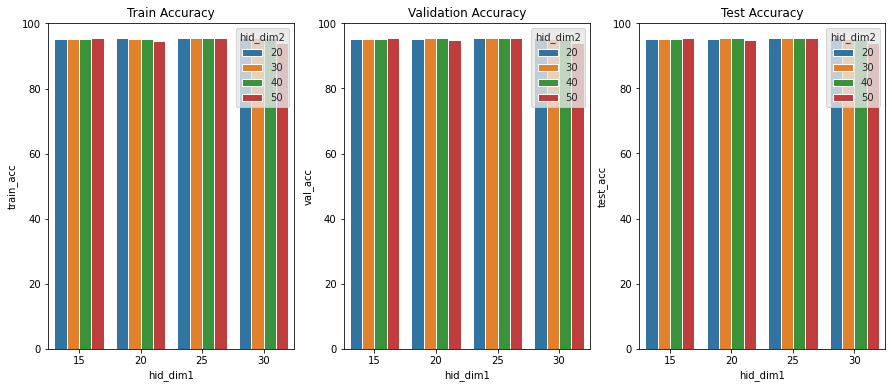

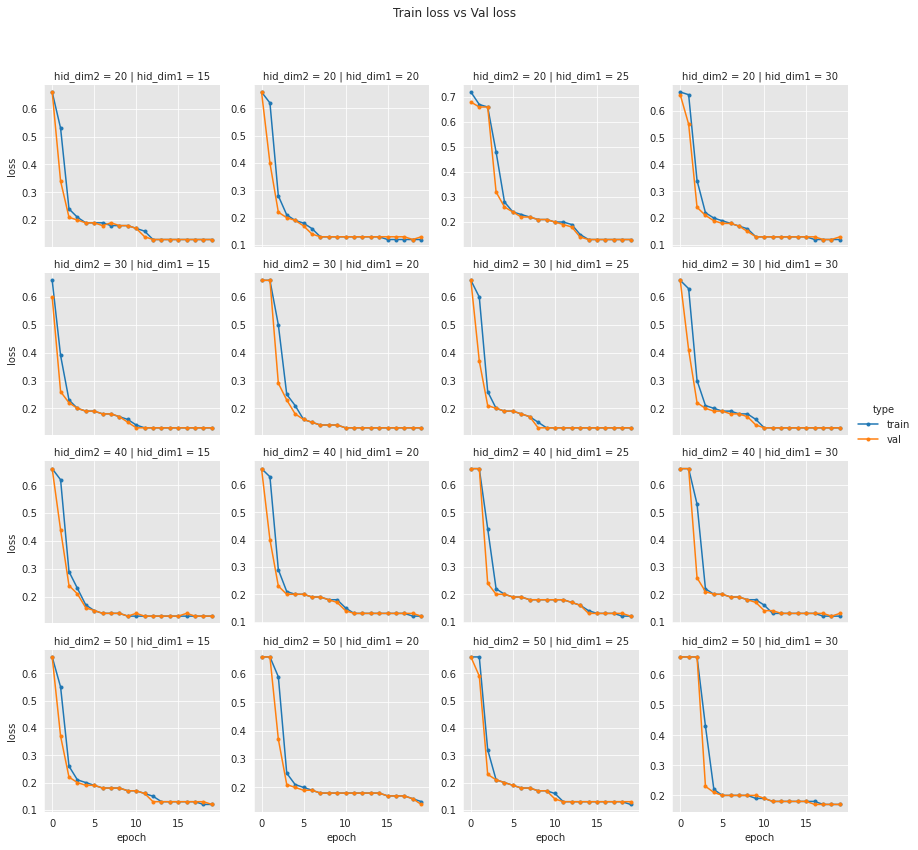

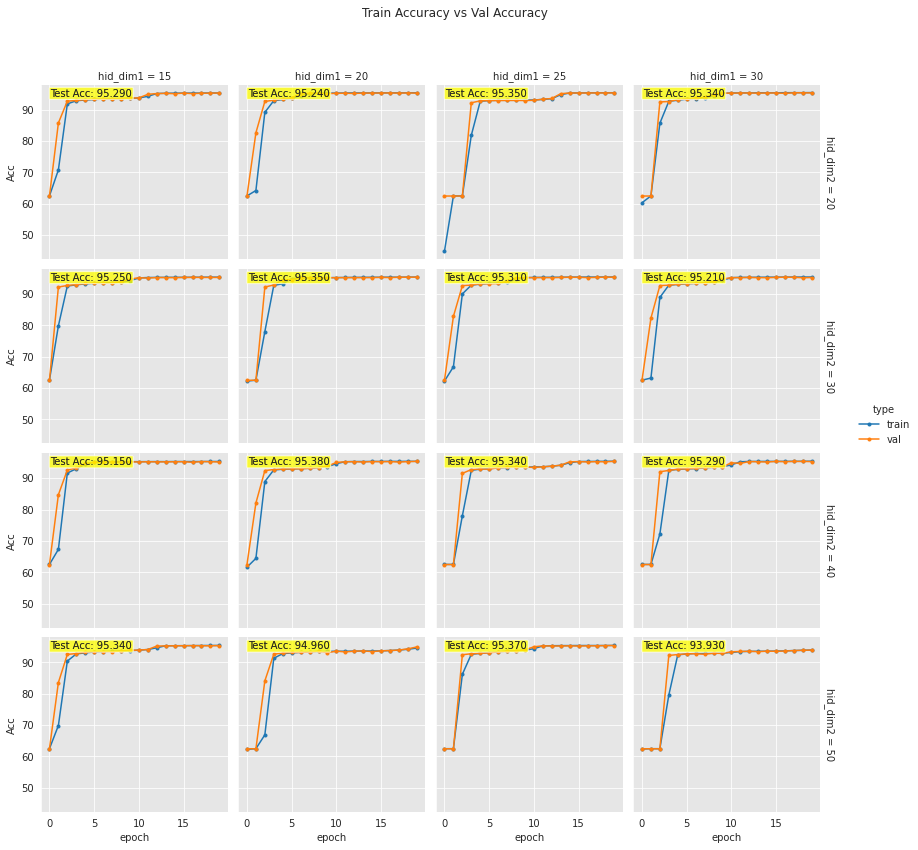

In [32]:
var1 = 'hid_dim1'
var2 = 'hid_dim2'
df = load_exp_result('exp')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.